In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import folium
import math
import json
from branca.colormap import LinearColormap
from branca.element import MacroElement
from jinja2 import Template
import matplotlib.pyplot as plt

In [2]:
protests_df = pd.read_csv('../Data_sinan/Protests.csv')
country_info_df = pd.read_csv('../Data_sinan/countryinfo.csv')
world_borders = json.load(open('../Data/world_borders.topojson.json'))
fips_codes = pd.read_csv('../Data/fipscountries.csv')
fips_codes = fips_codes[['fips','country']]
#democracy_df = pd.read_excel('../Data_sinan/WHR2018Chapter2OnlineData.xls')
#democracy_df = democracy_df[democracy_df['year']==2015][['country','Confidence in national government', 'Democratic Quality']]
happiness_df = pd.read_excel('../Data_sinan/WHR2018Chapter2OnlineData.xls', sheet_name='Figure2.2')
happiness_df = happiness_df[['Country','Happiness score']]
happiness_df.rename(index=str, columns={"Country": "country"}, inplace=True)
#happiness_df.loc[happiness_df['country']=='United States', 'country'] = 'United States of America'
#happiness_df.loc[happiness_df['country']=='Serbia', 'country'] = 'Republic of Serbia'
democracy_index_df =  pd.read_csv('../Data_sinan/democracy_index.csv')
democracy_index_df =  democracy_index_df[['Country', 'Score']]
democracy_index_df.rename(index=str, columns={"Country": "country", "Score": "Democratic Quality"}, inplace=True)


In [3]:
democracy_index_df

,country,Democratic Quality
0,Norway,9.87
1,Iceland,9.58
2,Sweden,9.39
3,New Zealand,9.26
4,Denmark,9.22
5,Ireland,9.15
6,Canada,9.15
7,Australia,9.09
8,Finland,9.03
9,Switzerland,9.03


In [4]:
protests_df = fips_codes.merge(protests_df, left_on='fips', right_on='LocEvent', how='inner')

In [5]:
protests_df.rename(index=str, columns={"f0_": "Number of protests"}, inplace=True)

In [6]:
population = country_info_df[['fips', 'population']]
protests_df = protests_df.merge(population, on='fips', how='inner')
protests_df = protests_df.merge(democracy_index_df, on='country', how='inner')
protests_df = protests_df.merge(happiness_df, on='country', how='inner')

In [7]:
protests_df['Relative number of protest'] = protests_df['Number of protests']/protests_df['population']
protests_df.sort_values(by='Relative number of protest', ascending=False).head()

,fips,country,Number of protests,LocEvent,population,Democratic Quality,Happiness score,Relative number of protest
57,IS,Israel,152028,IS,7353985,7.79,7.1900,0.020673
14,BA,Bahrain,10045,BA,738004,2.71,6.1051,0.013611
85,MK,Macedonia,25405,MK,2062294,5.57,5.1848,0.012319
90,MT,Malta,2478,MT,403000,8.15,6.6266,0.006149
61,IC,Iceland,1899,IC,308910,9.58,7.4952,0.006147


Let's visualize the number of the protest over the world:

In [8]:
def color_function(feature, data, color_fun):
    value = data.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    if math.isnan(value):
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_fun(value)

In [9]:
class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

In [10]:
world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display cantons' name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
_=folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(world_map)

In [11]:
protests_df.loc[protests_df['country']=='United States', 'country'] = 'United States of America'
protests_df.loc[protests_df['country']=='Serbia', 'country'] = 'Republic of Serbia'

protests_dict = protests_df.set_index('country')['Number of protests'].to_dict()
color_scale_protest = LinearColormap(['yellow','red'], \
                                     vmin = min(protests_dict.values()), \
                                     vmax = max(protests_dict.values()), \
                                     caption='Protests over the world'\
                                    )

map1 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, protests_dict, color_scale_protest),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Protests over the world',
    )

In [12]:
#protests_happiness_df.loc[protests_happiness_df['country']=='United States', 'country'] = 'United States of America'
#protests_happiness_df.loc[protests_happiness_df['country']=='Serbia', 'country'] = 'Republic of Serbia'

#democracy_dict = protests_happiness_df.set_index('country')['Democratic Quality'].to_dict()
democracy_dict = protests_df.set_index('country')['Democratic Quality'].to_dict()
color_scale_democracy = LinearColormap(['yellow','red'], \
                                     vmin = min(democracy_dict.values()), \
                                     vmax = max(democracy_dict.values()), \
                                     caption='Democracy quality over the world'\
                                    )

map2 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, democracy_dict, color_scale_democracy),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Democracy quality',
    )

In [13]:
population_dict = protests_df.set_index('country')['population'].to_dict()
color_scale_population = LinearColormap(['yellow','red'], \
                                     vmin = min(population_dict.values()), \
                                     vmax = max(population_dict.values()), \
                                     caption='Population over the world'\
                                    )

map3 = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, population_dict, color_scale_population),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Population',
    )

In [14]:
world_map.add_child(map1).add_child(map2).add_child(map3)
world_map.add_child(folium.map.LayerControl())

world_map.add_child(color_scale_protest)\
         .add_child(color_scale_democracy)\
         .add_child(color_scale_population)
         
world_map.add_child(BindColormap(map1, color_scale_protest)) \
         .add_child(BindColormap(map2, color_scale_democracy))\
         .add_child(BindColormap(map3, color_scale_population))
        
world_map

In [15]:
#protests_df = protests_happiness_df.merge(Democracy_df,\
#                                          left_on=['country','Confidence in national government', 'Democratic Quality'], \
#                                          right_on=['country','Confidence in national government', 'Democratic Quality'], \
#                                          how='inner')

In [16]:
def bootstrapping(data, number_of_sample, features, t=1.96):
    feature1 = features[0]
    feature2 = features[1]
    r = []
    sample_size = len(data)
    for i in range(number_of_sample):
        rnd_idx = np.random.randint(0, len(data), size=sample_size)
        data_sampled = data.iloc[rnd_idx]
        pearson_coeff = sp.stats.pearsonr(data_sampled[feature1], data_sampled[feature2])[0]
        # if the sample contains only identical values, the std is zero and pearsonr return NaN because of 
        # an impossible division by zero
        if not math.isnan(pearson_coeff):
            r.append(pearson_coeff)
     
    r_mean = np.mean(r) 
    z = np.log((1+r_mean)/(1-r_mean))/2
    std_err = 1/np.sqrt(sample_size-3)
    lower_z = z - std_err*t
    upper_z = z + std_err*t
    
    lower_r = (np.exp(2*lower_z)-1)/(np.exp(2*lower_z)+1)
    upper_r = (np.exp(2*upper_z)-1)/(np.exp(2*upper_z)+1)
    CI = (lower_r, upper_r)
    return r , CI

,Number of protests,population,Democratic Quality,Happiness score
Number of protests,1,0.38795,0.125227,0.145856
population,0.38795,1,-0.0266584,-0.0438891
Democratic Quality,0.125227,-0.0266584,1,0.626226
Happiness score,0.145856,-0.0438891,0.626226,1


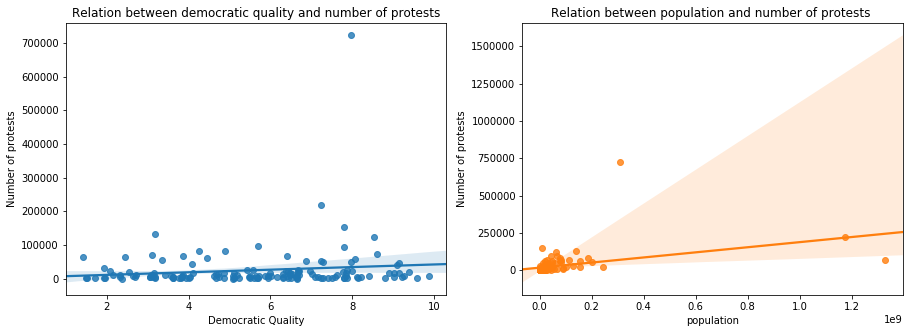

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_df, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=protests_df, ax=axs[1])

corr = protests_df[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()

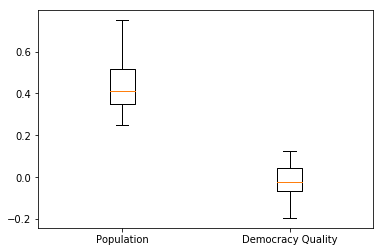

In [32]:
number_of_sample = 100
population_coefs, population_coef_ci = bootstrapping(protests_df, number_of_sample, features=['population', 'Number of protests'])
democracy_coefs, democracy_coef_ci = bootstrapping(protests_df, number_of_sample, features=['population', 'Democratic Quality'])
_=plt.boxplot([population_coefs, democracy_coefs], 
              labels=["Population", "Democracy Quality"], 
              conf_intervals=[population_coef_ci, democracy_coef_ci]
             )

,Number of protests,population,Democratic Quality,Happiness score
Number of protests,1,0.411544,-0.0212044,0.0618218
population,0.411544,1,0.0566812,0.07977
Democratic Quality,-0.0212044,0.0566812,1,0.0716688
Happiness score,0.0618218,0.07977,0.0716688,1


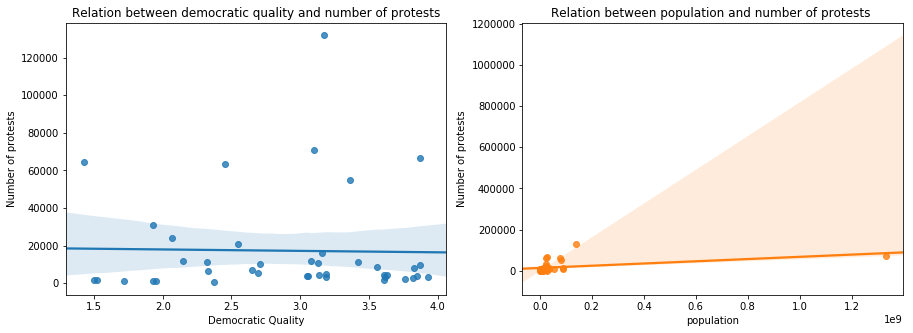

In [18]:
democratic_countries_protests = protests_df[(protests_df['Democratic Quality']<4)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()

In [33]:
number_of_sample = 100
population_coefs, population_coef_ci = bootstrapping(democratic_countries_protests, number_of_sample, features=['population', 'Number of protests'])
democracy_coefs, democracy_coef_ci = bootstrapping(democratic_countries_protests, number_of_sample, features=['population', 'Democratic Quality'])
_=plt.boxplot([population_coefs, democracy_coefs], 
              labels=["Population", "Democracy Quality"], 
              conf_intervals=[population_coef_ci, democracy_coef_ci]
             )

ValueError: low >= high

,Number of protests,population,Democratic Quality,Happiness score
Number of protests,1,0.647945,-0.192384,0.14381
population,0.647945,1,-0.274736,0.111764
Democratic Quality,-0.192384,-0.274736,1,0.0305475
Happiness score,0.14381,0.111764,0.0305475,1


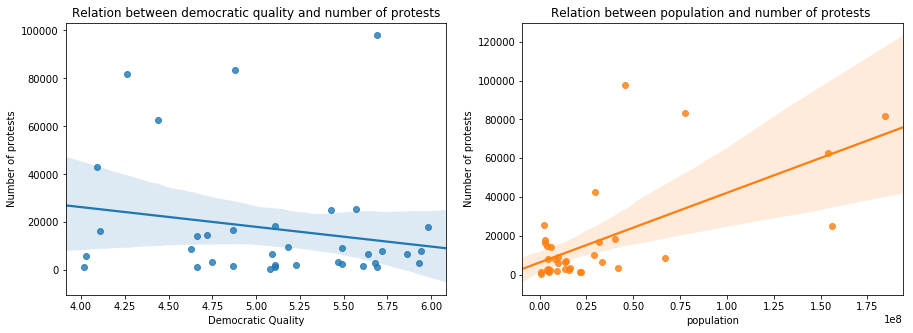

In [19]:
democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=4)&(protests_df['Democratic Quality']<6)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()

,Number of protests,population,Democratic Quality,Happiness score
Number of protests,1,0.467003,0.298767,0.217498
population,0.467003,1,0.0749619,-0.17154
Democratic Quality,0.298767,0.0749619,1,0.360055
Happiness score,0.217498,-0.17154,0.360055,1


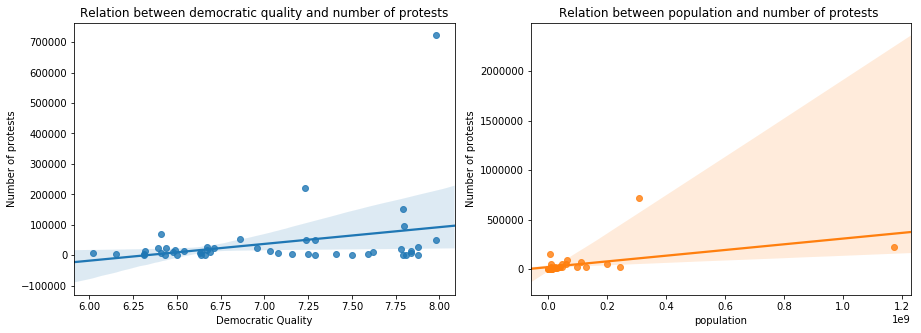

In [20]:
democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=6)&(protests_df['Democratic Quality']<8)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()

,Number of protests,population,Democratic Quality,Happiness score
Number of protests,1,0.857685,-0.20408,-0.139471
population,0.857685,1,-0.340479,-0.277525
Democratic Quality,-0.20408,-0.340479,1,0.84996
Happiness score,-0.139471,-0.277525,0.84996,1


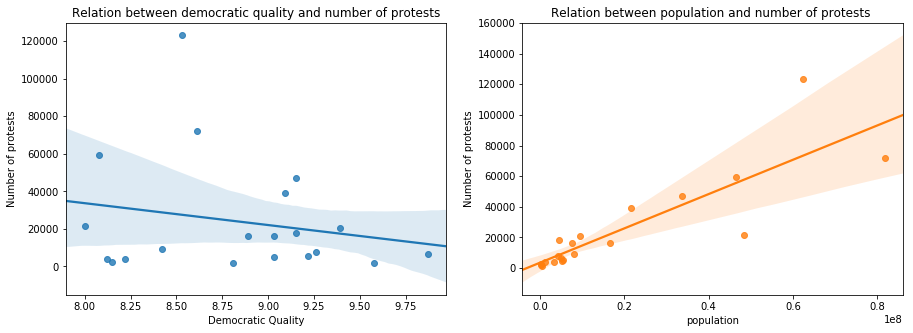

In [21]:
democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=8)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()

ValueError: low >= high

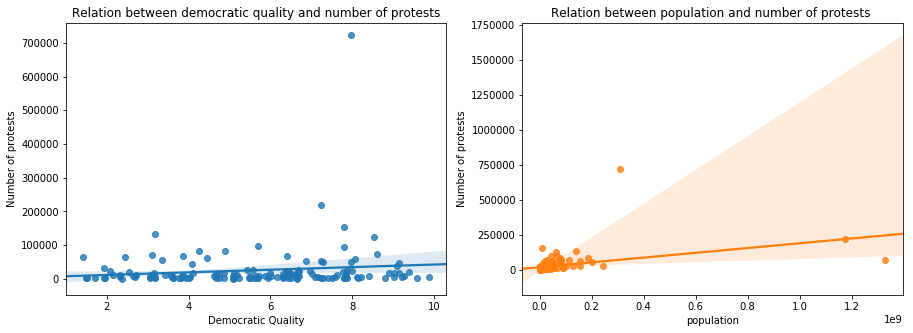

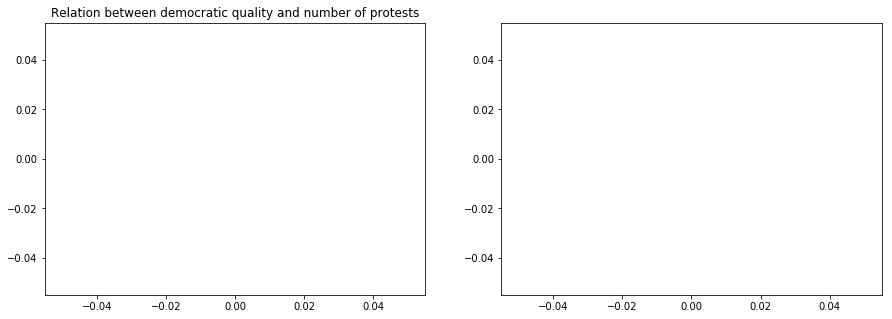

In [22]:
democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=0.5)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()



democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=-1.5)&(protests_df['Democratic Quality']<-1)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality', 'Happiness score']].corr()
corr.style.background_gradient()



democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=0.5)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()



more_democratic_countries_protests = protests_df[protests_df['Democratic Quality']>=1]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=more_democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=more_democratic_countries_protests, ax=axs[1])


corr = more_democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()



not_democratic_countries_protests = protests_df[(protests_df['Democratic Quality']>=-2) & (protests_df['Democratic Quality']<-1)]
#democratic_countries_protests = democratic_countries_protests[democratic_countries_protests['population']<100000000]                                    

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=not_democratic_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=not_democratic_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = not_democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()


In [ ]:
populated_countries_protests = protests_df[(protests_df['population']>=50000000)]#&(protests_df['Democratic Quality']<0.5)]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=populated_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=populated_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = populated_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

In [ ]:
populated_countries_protests = protests_df[(protests_df['population']>=50000000)]#&(protests_df['Democratic Quality']<0.5)]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=populated_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=populated_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = populated_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

In [ ]:
populated_countries_protests = protests_df[(protests_df['population']>=20000000)&(protests_df['population']<50000000)]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=populated_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=populated_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = populated_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

In [ ]:
populated_countries_protests = protests_df[(protests_df['population']>=0)&(protests_df['population']<20000000)]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Democratic Quality', 'Number of protests', data=populated_countries_protests, ax=axs[0])
#_=sn.regplot('Democratic Quality', 'Number of protests', data=protests_happiness_df, ax=axs[0])

axs[1].set_title('Relation between population and number of protests ')
_=sn.regplot('population', 'Number of protests', data=populated_countries_protests, ax=axs[1])
#sn.regplot('population', 'Number of protests', data=democratic_countries_protests)

corr = populated_countries_protests[['Number of protests', 'population', 'Democratic Quality']].corr()
corr.style.background_gradient()

In [ ]:
number_of_sample = 100
pearson_coefs, pearson_coef_ci = bootstrapping(protests_df, number_of_sample, features=['population', 'Number of protests'])
_=plt.boxplot([pearson_coefs], conf_intervals=[pearson_coef_ci])

In [ ]:
number_of_sample = 100
pearson_coefs, pearson_coef_ci = bootstrapping(democratic_countries_protests, number_of_sample, features=['population', 'Number of protests'])
_=plt.boxplot([pearson_coefs], conf_intervals=[pearson_coef_ci])

In [ ]:
democratic_countries_protests = democratic_countries_protests[['Number of protests', 'population', 'Democratic Quality']]
corr = democratic_countries_protests.corr()
corr.style.background_gradient()